# Dataset Description

The dataset lists Moscow Metro, Monorail, and MCC (Moscow Central Circle) stations as of 2017 with their main characteristics.


Feature | Description
-------------------|--------------------
station_name |Name of the station.
station_number |Serial number of the station on the line.
line_number|Line number.
line_number.alt|Line name.
perehod|Presence of a transfer to another line.
perehod.alt|Description of the transfer.
depth|Depth of the station, m.
opening_date|Date of opening.
potok|Passenger flow.
latitude|Latitude.
longitude|Longitude.

# Data Loading and Preprocessing

Importing libraries:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


Loading data into a dataframe:

In [ ]:
df = pd.read_csv("Moscow_subway.csv", sep = ",", index_col = 0, header = 0, decimal = ".")
df

,station_number,line_number,line_number.alt,perehod,perehod.alt,depth,opening_date,potok,latitude,longitude
station_name,,,,,,,,,,
Сокольники,4,1,Сокольническая,NaN,NaN,-9,1935-05-15,75400.0,"55,78888889","37,68027778"
Красносельская,5,1,Сокольническая,NaN,NaN,-8,1935-05-15,25100.0,"55,78","37,66722222"
Комсомольская,6,1,Сокольническая,5,Переход на станцию Комсомольская Кольцевой линии,-8,1935-05-15,59000.0,"55,77527778","37,65611111"
Красные Ворота,7,1,Сокольническая,NaN,NaN,-31,1935-05-15,44000.0,"55,76888889","37,64861111"
Чистые пруды,8,1,Сокольническая,6,Переход на станцию Тургеневская Калужско-Рижск...,-35,1935-05-15,29200.0,"55,76583333","37,63888889"
...,...,...,...,...,...,...,...,...,...,...
Зорге,26,14,Московское центральное кольцо,NaN,NaN,NaN,2016-11-04,NaN,"55,78916667","37,50416667"
Панфиловская,27,14,Московское центральное кольцо,7,Переход на станцию Октябрьское поле Таганско-К...,NaN,2016-11-08,NaN,"55,79805556","37,49972222"
Раменки,1,8А,Солнцевская,NaN,NaN,-15,2017-03-16,NaN,"55,69611111","37,50527778"


Let's look at the main statistics calculated for this dataset:

In [ ]:
df.describe()

,station_number,potok
count,243.000000,199.000000
mean,10.868313,43311.055276
std,7.241349,26996.114168
min,1.000000,1000.000000
25%,5.000000,25850.000000
50%,10.000000,39400.000000
75%,16.500000,55850.000000
max,31.000000,181900.000000


# Data Cleaning
We see that the table initially appears to have only 2 columns with data, but this is incorrect.

* In some cells, data was not specified, so they appear as $NaN$.

* Some cells are empty for an obvious reason: there is no station or line to transfer to. In this case, we replace $NaN$ with `"No transfer"` and `0` respectively.

* If the station depth is not specified, it is not an underground structure, but an MCC platform. To avoid confusing them with ground-level metro stations, we will set their depth to $+1$ m.

* However, rows with unknown passenger flow will have to be deleted.

* We will remove outliers and add more data by converting columns (including the opening date) to a numerical format.

Let's look at the result:

In [ ]:
clean_df = df.copy()
clean_df['perehod'].fillna(0, inplace=True)
clean_df['perehod.alt'].fillna('Нет перехода', inplace=True)
clean_df['depth'].fillna(1, inplace=True)
clean_df.dropna(axis=0, inplace=True)

# Standartizing coordinate formats
clean_df['latitude'] = clean_df['latitude'].str.replace(',', '.')
clean_df['longitude'] = clean_df['longitude'].str.replace(',', '.')
clean_df['depth'] = clean_df['depth'].str.replace(',', '.')

# Converting to float
clean_df['latitude'] = clean_df['latitude'].astype(float)
clean_df['longitude'] = clean_df['longitude'].astype(float)
clean_df['depth'] = clean_df['depth'].astype(float)

# Handling dates
clean_df['opening_date'] = pd.to_datetime(clean_df['opening_date'])
clean_df['newness'] = (clean_df['opening_date'] - clean_df['opening_date'].min()).dt.days + 1
clean_df.describe()

,station_number,depth,opening_date,potok,latitude,longitude,newness
count,199.000000,199.000000,199,199.000000,199.000000,199.000000,199.000000
mean,10.572864,-21.500000,1975-08-09 18:27:08.140703520,43311.055276,55.733543,37.609761,14697.768844
min,1.000000,-73.600000,1935-05-15 00:00:00,1000.000000,55.538056,37.354444,1.000000
25%,5.000000,-39.550000,1958-08-04 00:00:00,25850.000000,55.689306,37.557083,8483.000000
50%,10.000000,-10.500000,1975-12-17 00:00:00,39400.000000,55.745000,37.608889,14827.000000
75%,16.000000,-8.000000,1992-01-30 12:00:00,55850.000000,55.778611,37.657639,20715.500000
max,25.000000,10.000000,2016-09-16 00:00:00,181900.000000,55.898056,37.863889,29711.000000
std,6.580002,19.317684,NaN,26996.114168,0.073883,0.098495,8659.127745


We now have seven columns (though we will use only 6, because `newness` replaced `opening_date`). Let's build a boxplot to check the scale of the data:





<Axes: >

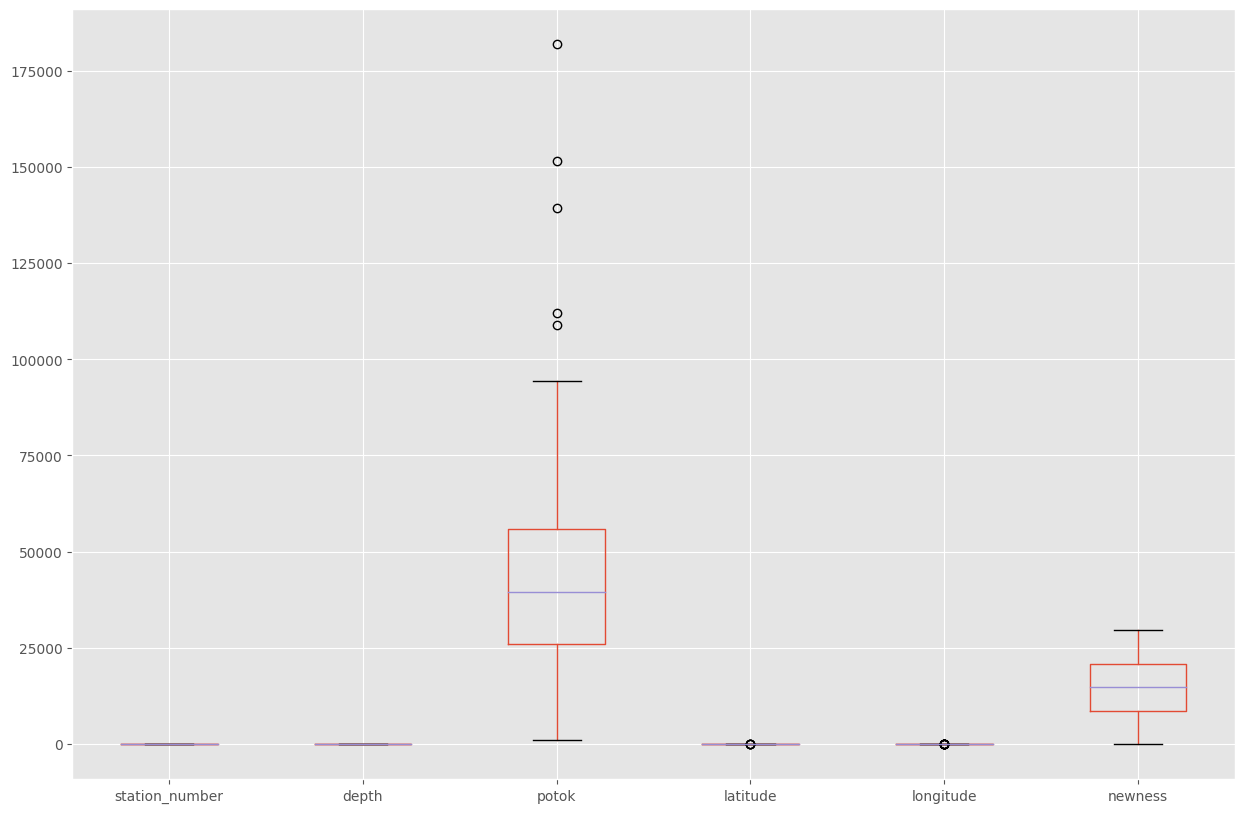

In [ ]:
clean_df.boxplot(figsize=(15,10))

# Standardization
The numeric values have different orders of magnitude, so they must be standardized before processing. We will use `MinMaxScaler()` because we want to preserve the distance between opening dates.



In [ ]:
standard_scaler = MinMaxScaler()
float_df = clean_df[['station_number', 'depth', 'potok', 'latitude', 'longitude', 'newness']]
standard_df = pd.DataFrame(data = standard_scaler.fit_transform(float_df), index = float_df.index, columns = float_df.columns)
standard_df

,station_number,depth,potok,latitude,longitude,newness
station_name,,,,,,
Сокольники,0.125000,0.772727,0.411277,0.696759,0.639586,0.000000
Красносельская,0.166667,0.784689,0.133223,0.672068,0.613959,0.000000
Комсомольская,0.208333,0.784689,0.320619,0.658951,0.592148,0.000000
Красные Ворота,0.250000,0.509569,0.237700,0.641204,0.577426,0.000000
Чистые пруды,0.291667,0.461722,0.155887,0.632716,0.558342,0.000000
...,...,...,...,...,...,...
Котельники,0.916667,0.700957,0.099502,0.378086,0.989095,0.987849
Технопарк,0.541667,0.880383,0.105030,0.435957,0.607961,0.991148
Румянцево,0.833333,0.736842,0.138198,0.263889,0.171756,0.991855


Let's look at the boxplot again to ensure everything looks visually correct.

<Axes: >

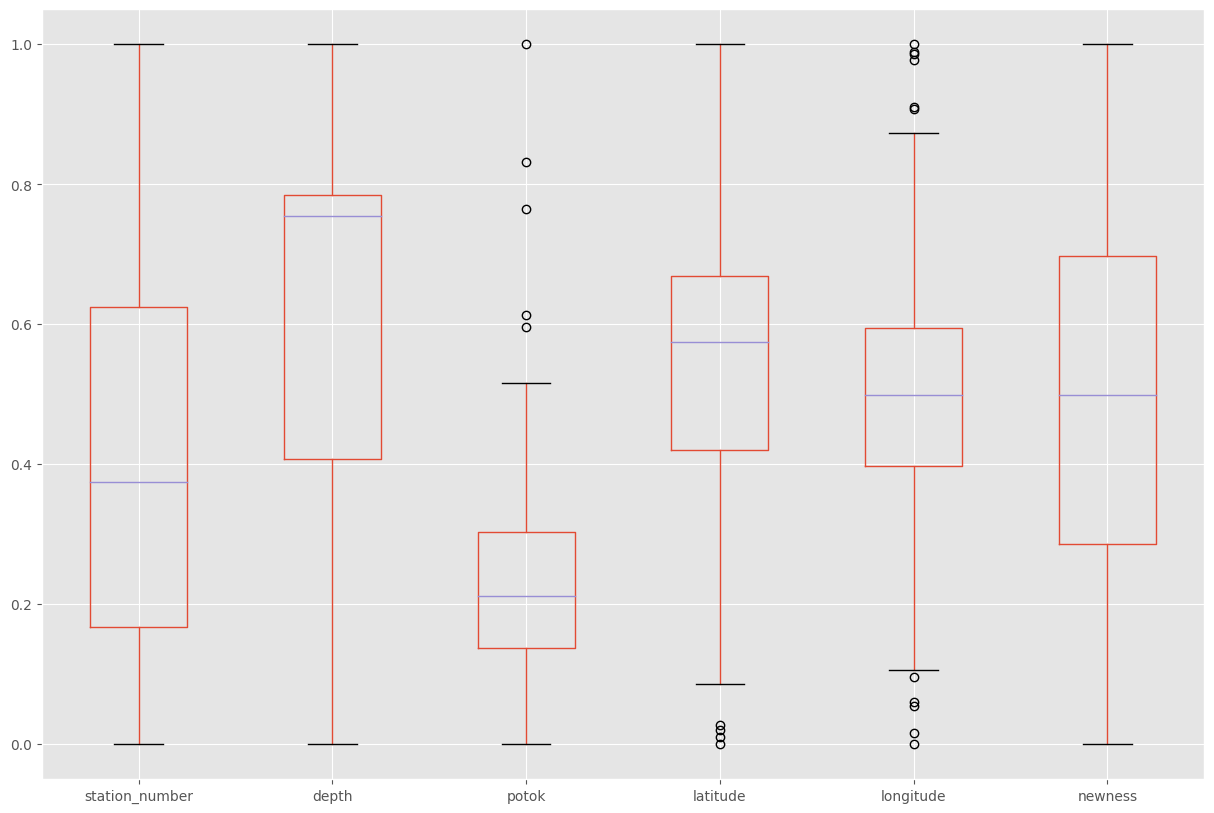

In [ ]:
standard_df.boxplot(figsize=(15,10))

We see that all values are now of the same order. There are a few stations with outlying passenger flows and some very distant stations, but they are not errors.

# Visualization

Let's check if everything imported correctly by plotting longitude vs. latitude.

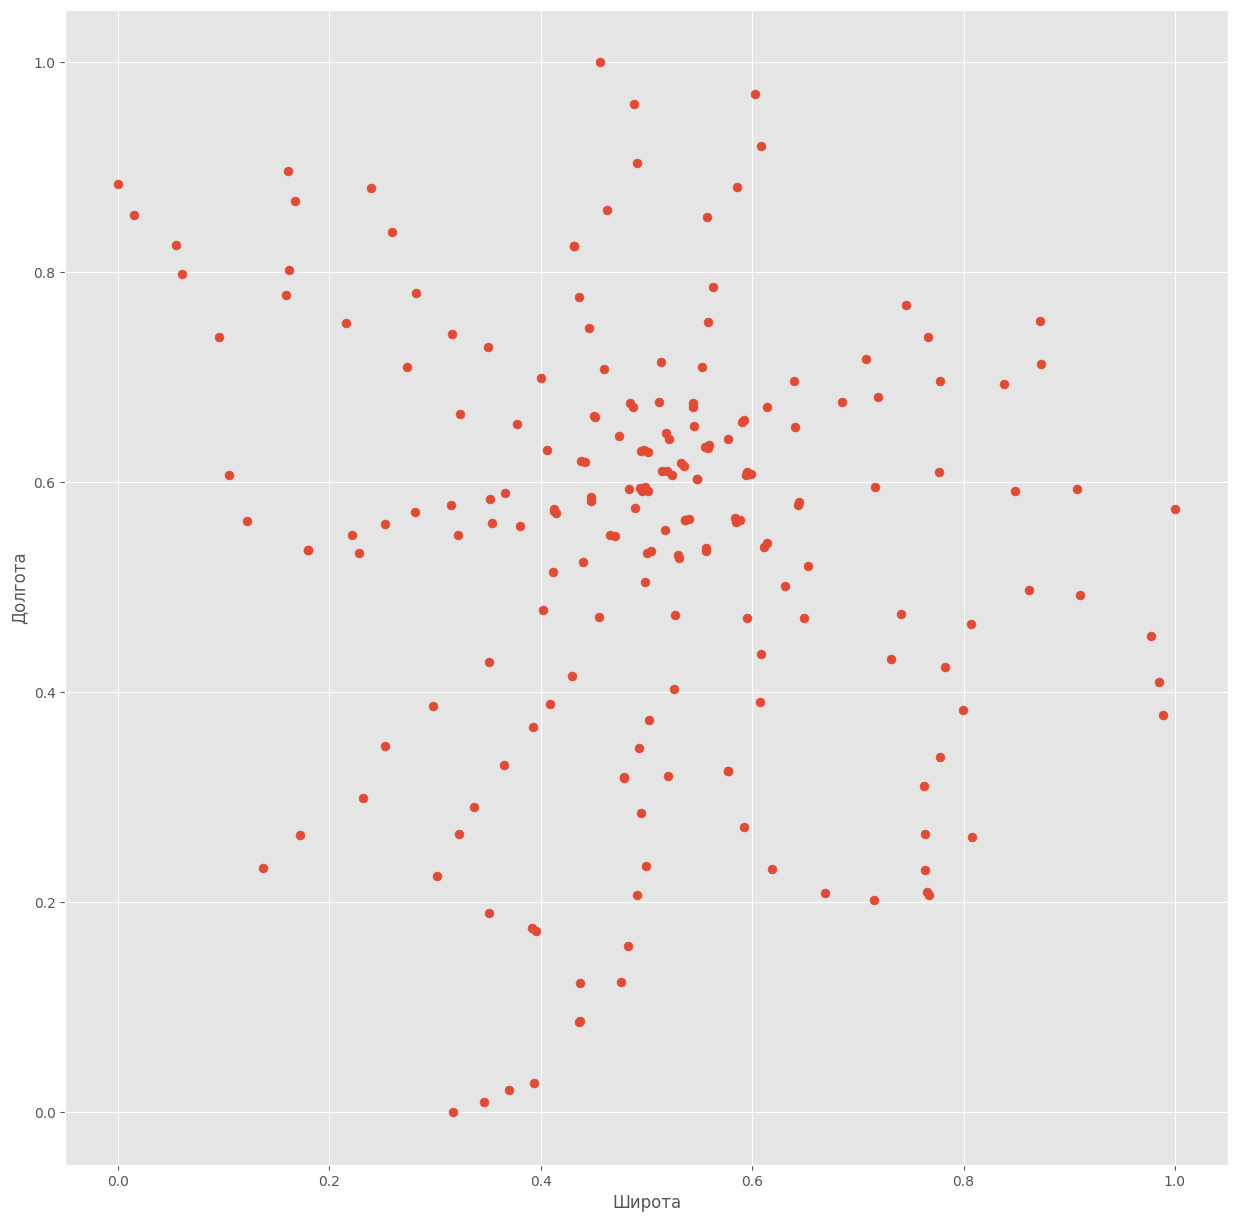

In [ ]:
map = plt.figure(figsize=(15,15)).add_subplot(projection='rectilinear')
map.scatter(standard_df["longitude"], standard_df["latitude"], alpha = 1, s =40)
map.set_xlabel('Широта')
map.set_ylabel('Долгота')
plt.show()

Obviously, this looks like the metro map as of 2017: https://b1.m24.ru/c/989158.jpg

Data is prepared.

# Problem Statement and Model Building

Our Goal: To find out if Moscow metro stations can be clustered by main parameters and attempt to explain what causes this clustering (what the resulting groups represent).

We will solve two clustering tasks and study:

1. The dependence of passenger flow on the station's location.

2. The interdependence of three variables: passenger flow, station depth, and construction time.

We will use the k-means method. We will attempt to determine an adequate number of clusters (exploring the range from 1 to 10).

In [ ]:
first_df = float_df.copy()
first_df = first_df[['potok', 'latitude', 'longitude']]

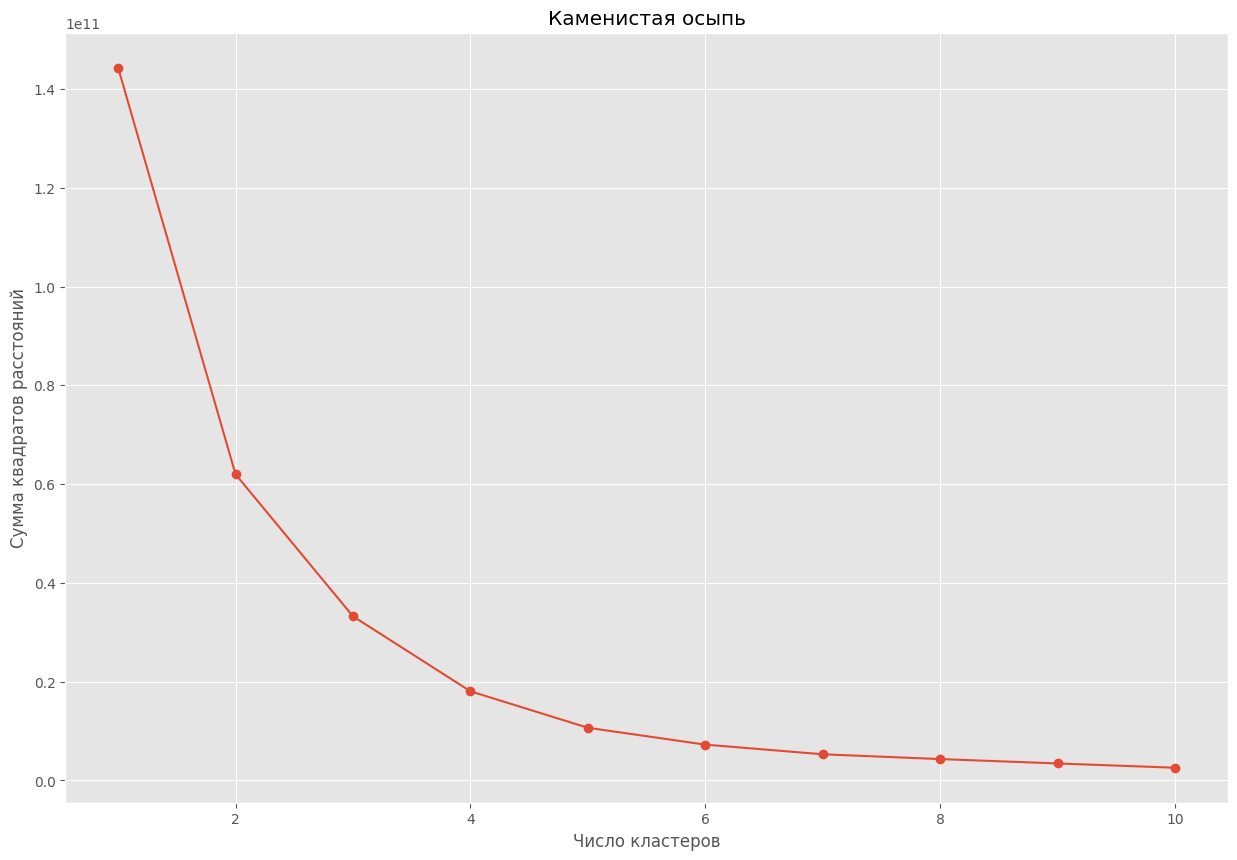

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 111, n_init = 100, max_iter = 10000).fit(first_df) for k in K]
dist = [model.inertia_ for model in models]

plt.figure(figsize=(15,10))
plt.plot(K, dist, marker='o')
plt.xlabel('Cluster number')
plt.ylabel('Sum of the squares of the distances')
plt.title('Scree plot')
plt.show()

From the graph ("Scree Plot"), it is clear that it makes sense to consider a range of 2 to 6 clusters. Beyond that, the inflection is not as significant.

# Clustering "Passenger Flow - Coordinate"

Since we can only visualize three axes, we will choose three features at a time. Let's start with two coordinates and passenger flow.

**Null Hypothesis:** The closer the station is to the center, the more passengers it has. We will perform clustering for each case (2 to 6 clusters) and visualize the results in 3D.

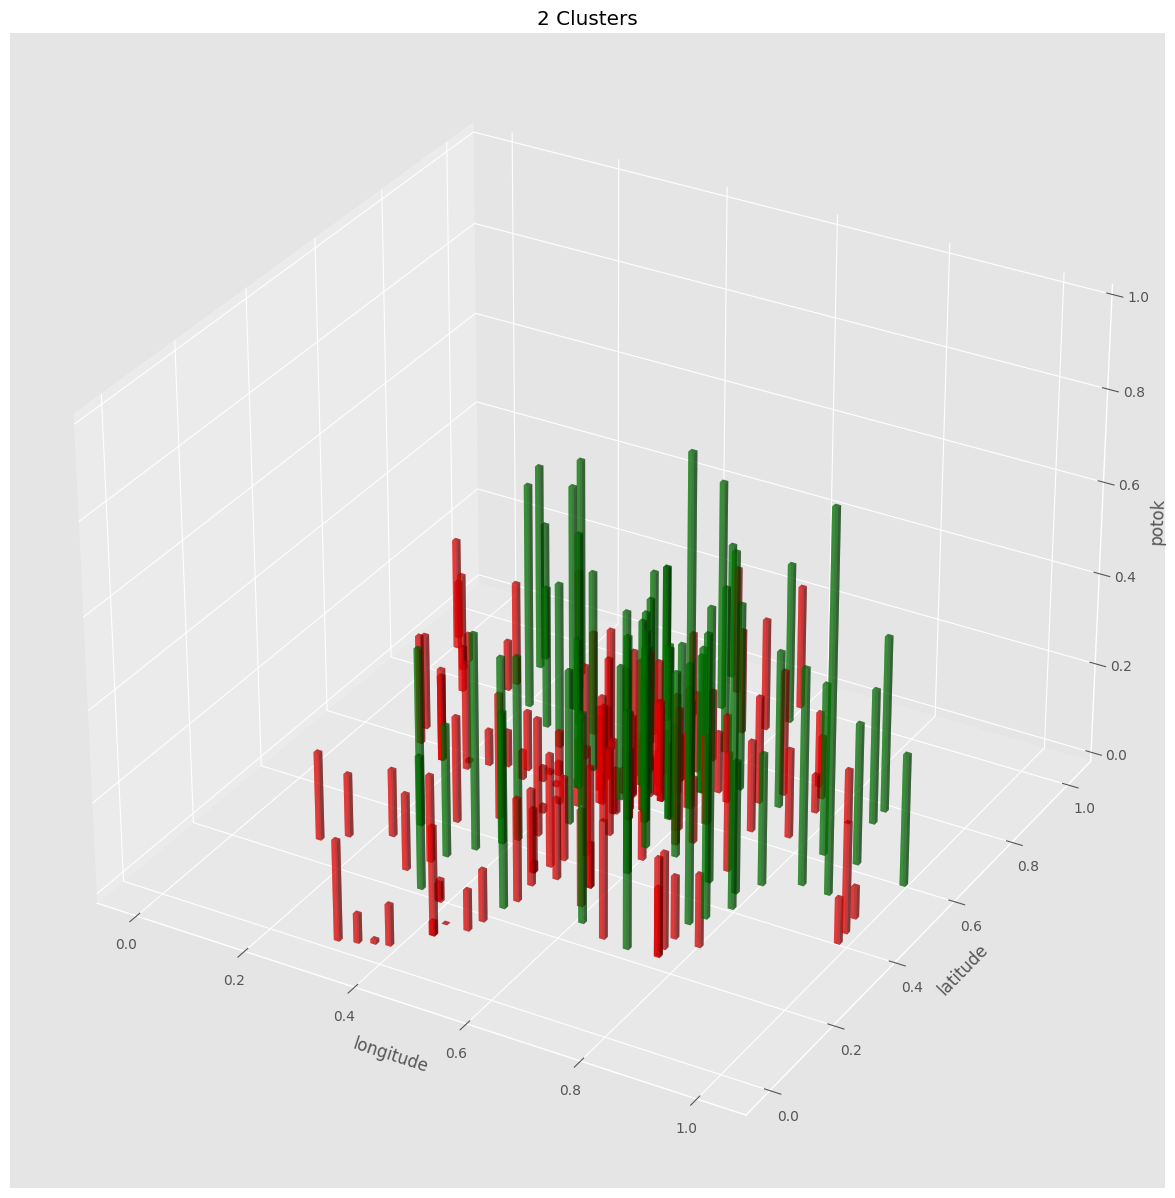

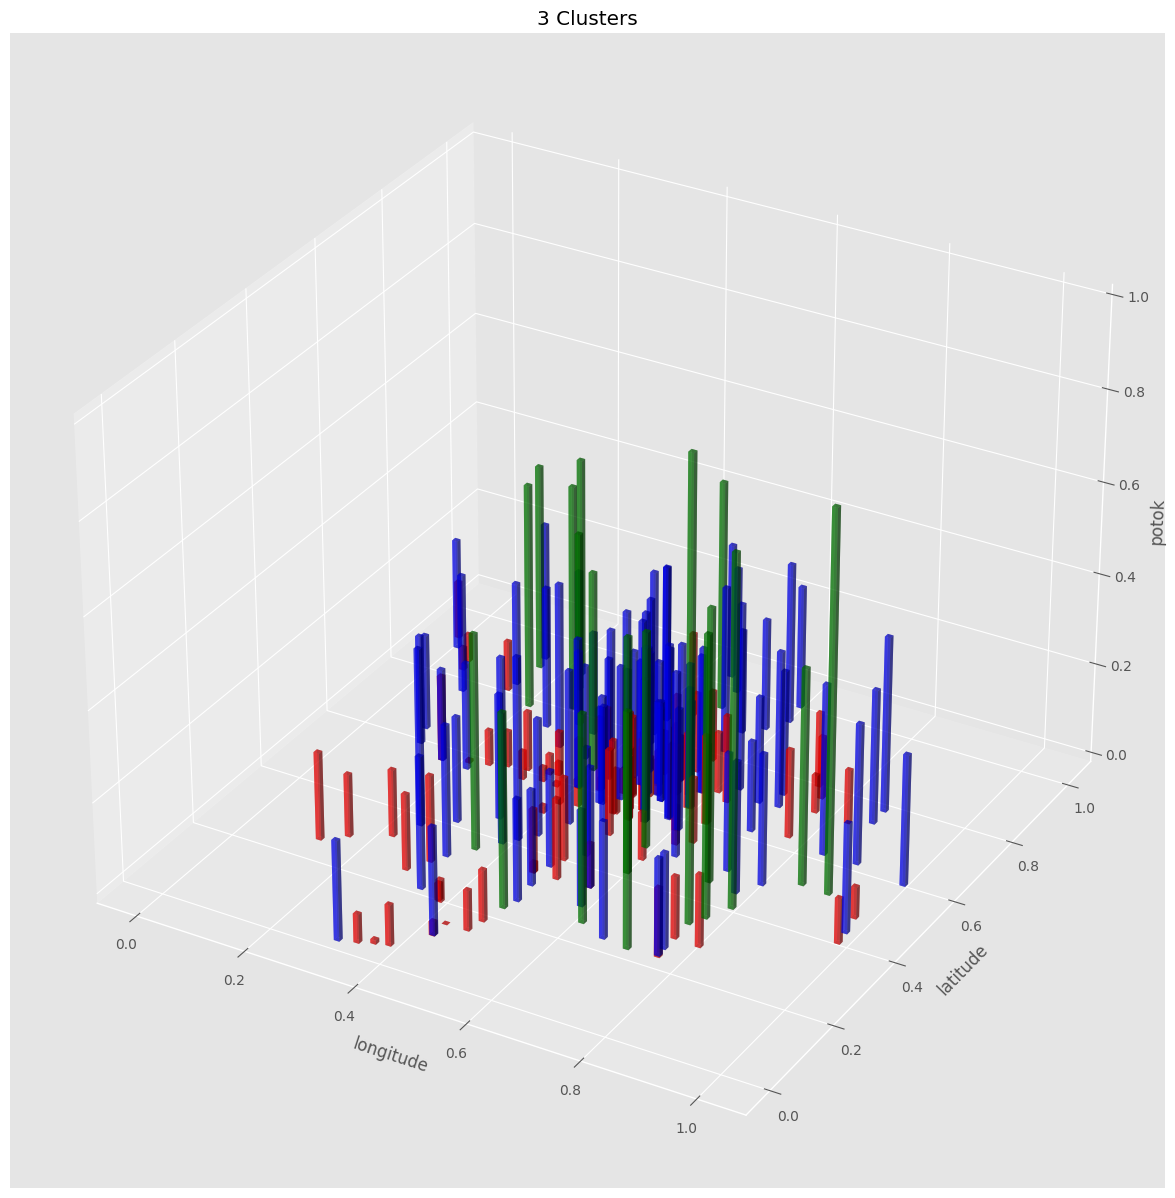

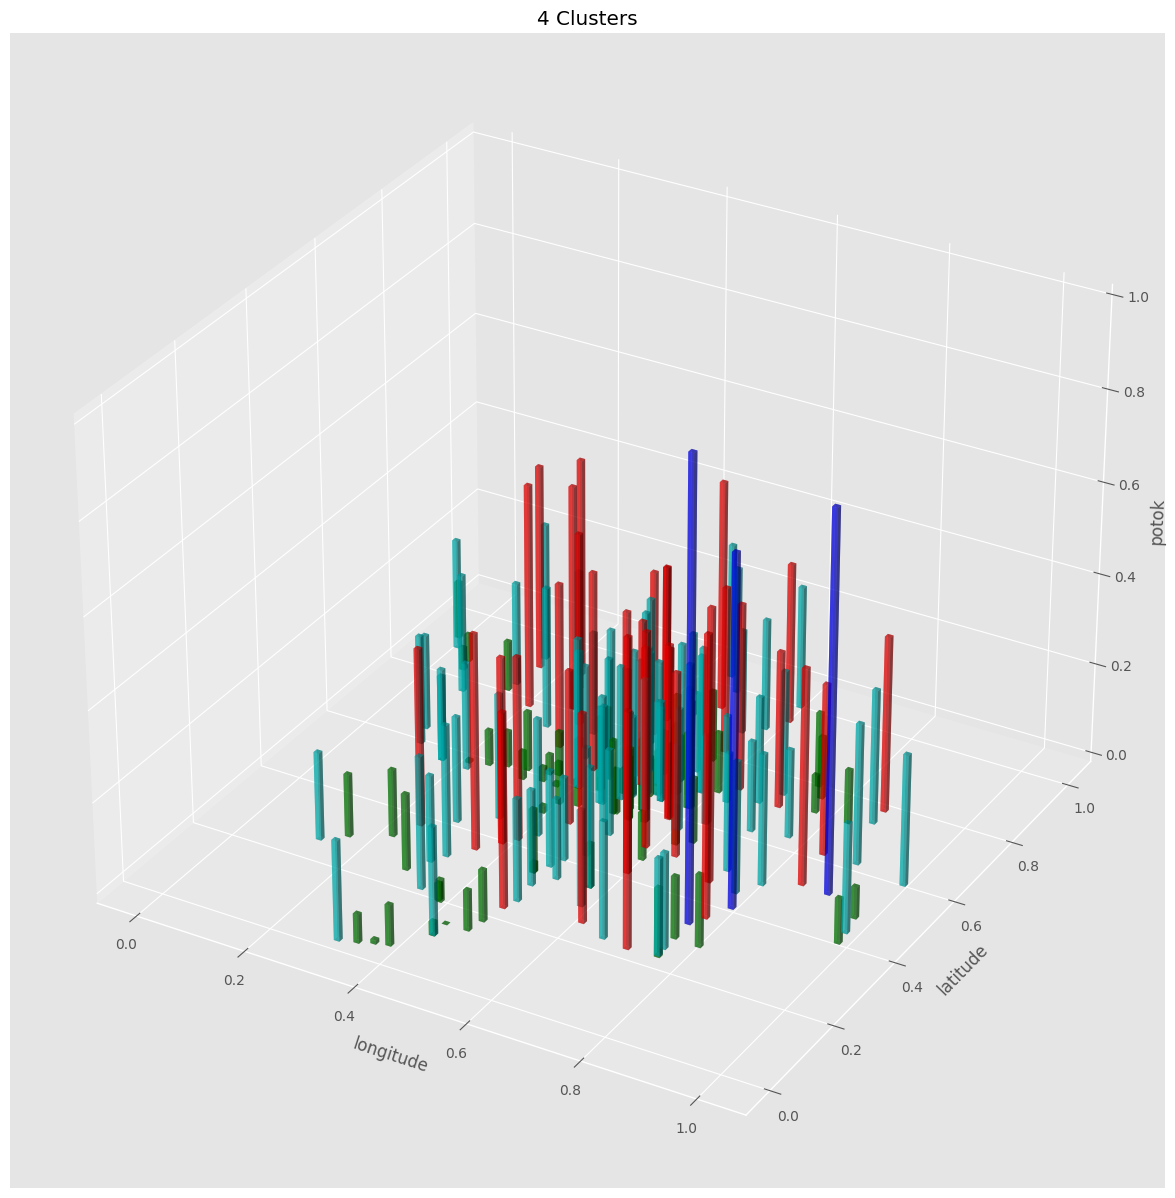

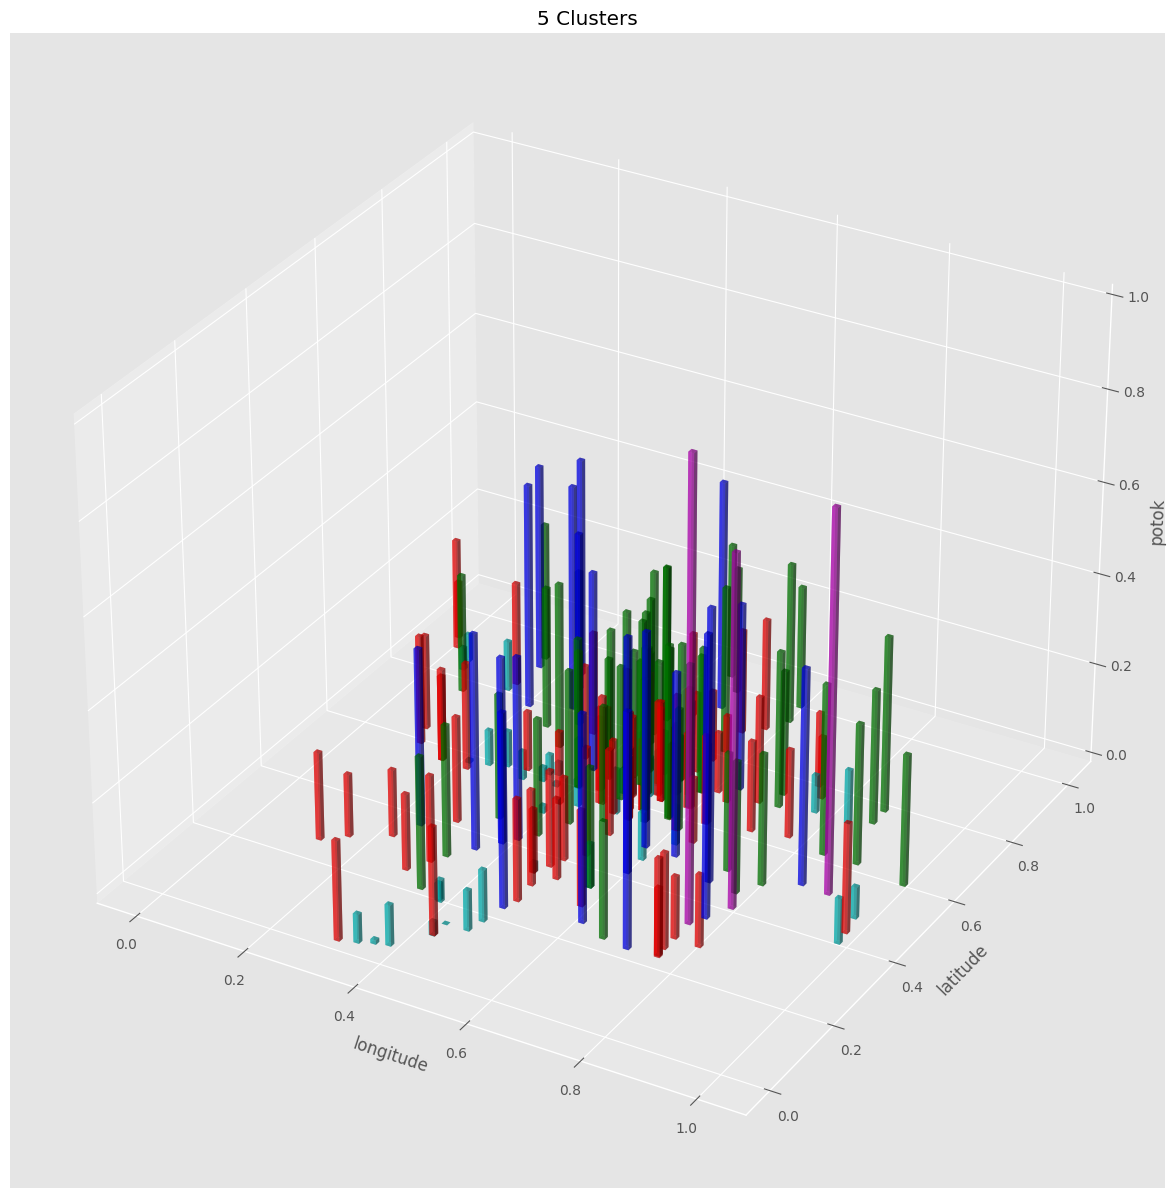

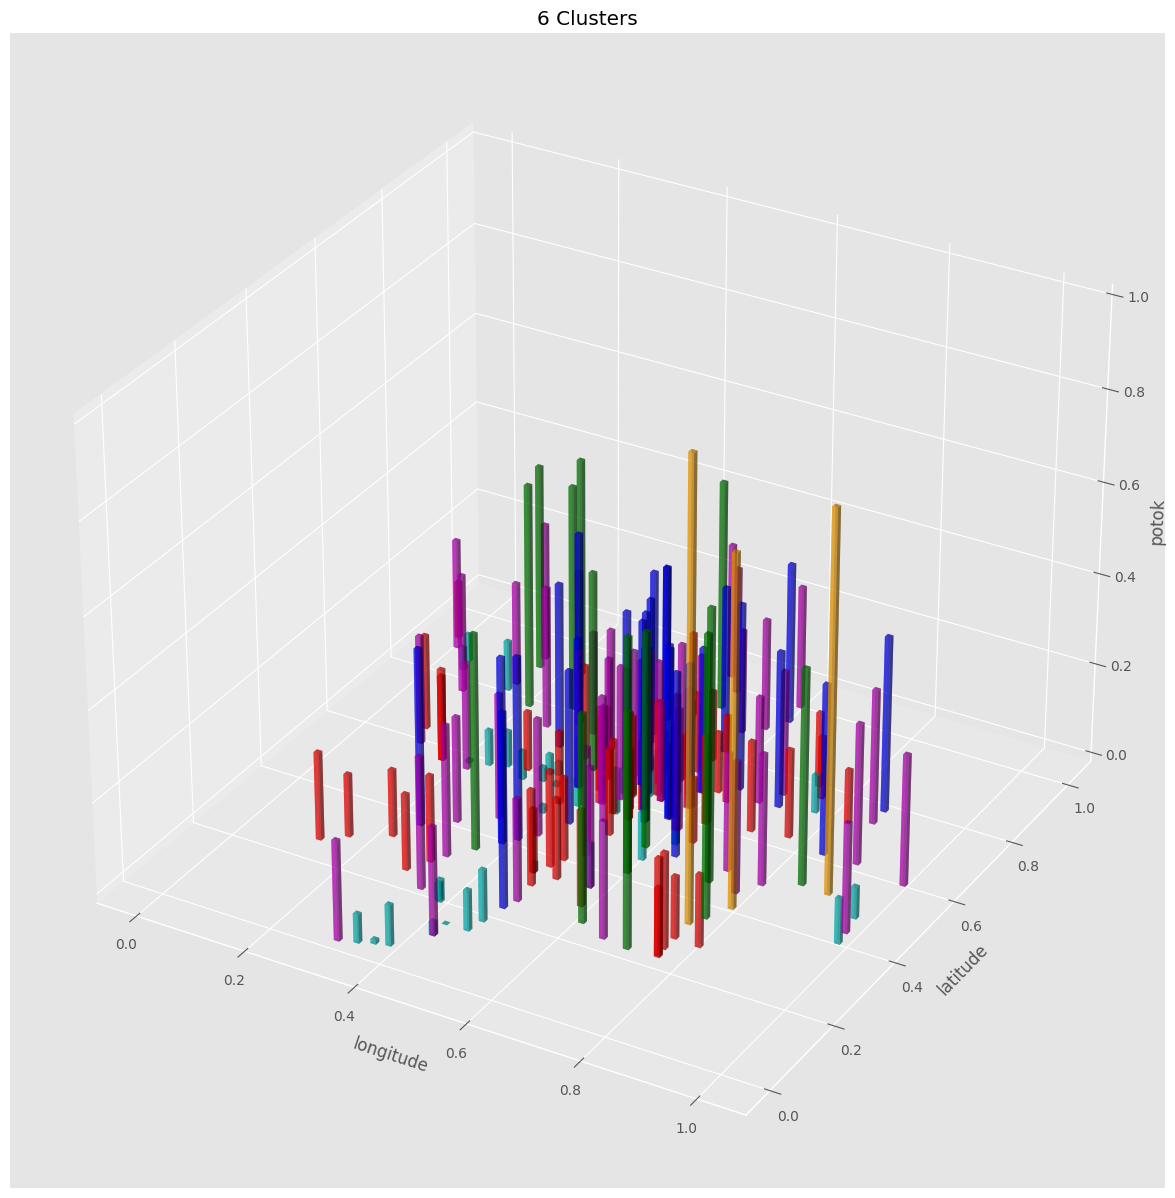

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(first_df)

    first_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_  # Cluster centers to define the colors

    threedee = plt.figure(figsize=(15, 15)).add_subplot(projection='3d')

    for j in range(len(standard_df)):
        x = standard_df["longitude"][j]
        y = standard_df["latitude"][j]
        z = standard_df["potok"]
        cluster_label = model.labels_[j]
        threedee.bar3d(x, y, 0, 0.01, 0.01, z[j], color=colors[cluster_label], alpha=0.5)

    threedee.set_xlabel('longitude')
    threedee.set_ylabel('latitude')
    threedee.set_zlabel('potok')
    threedee.set_title(f'{i} Clusters')
    plt.show()

Alas, 3D visualization is hard to read. Let's build a 2D diagram where the dot size depends on passenger flow.

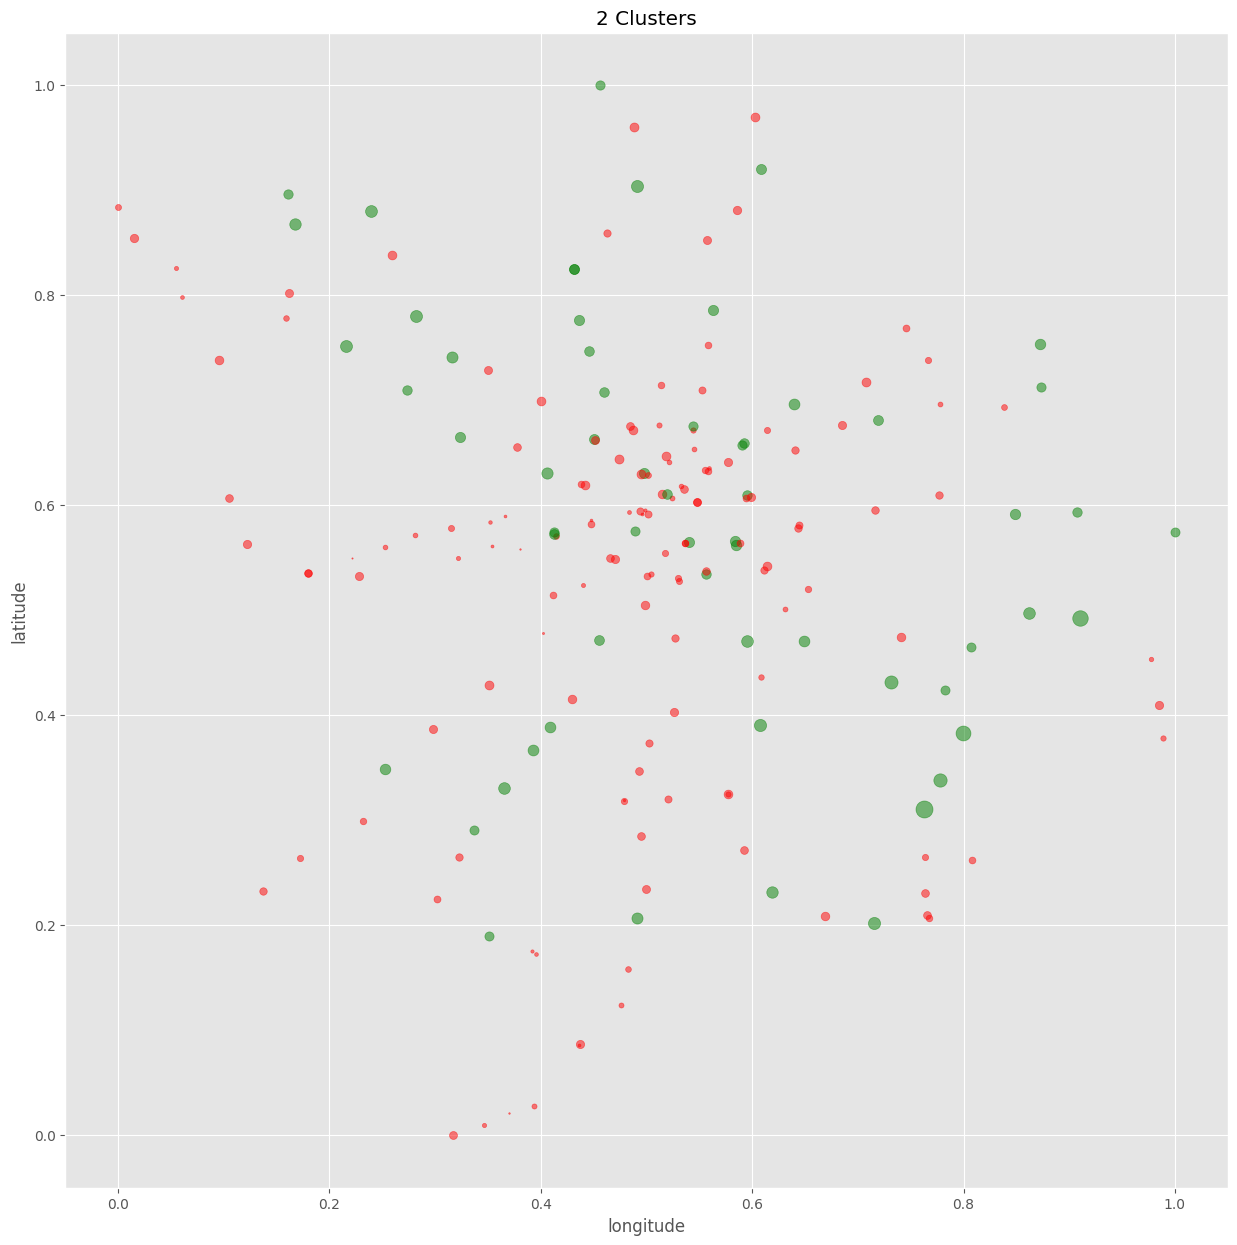

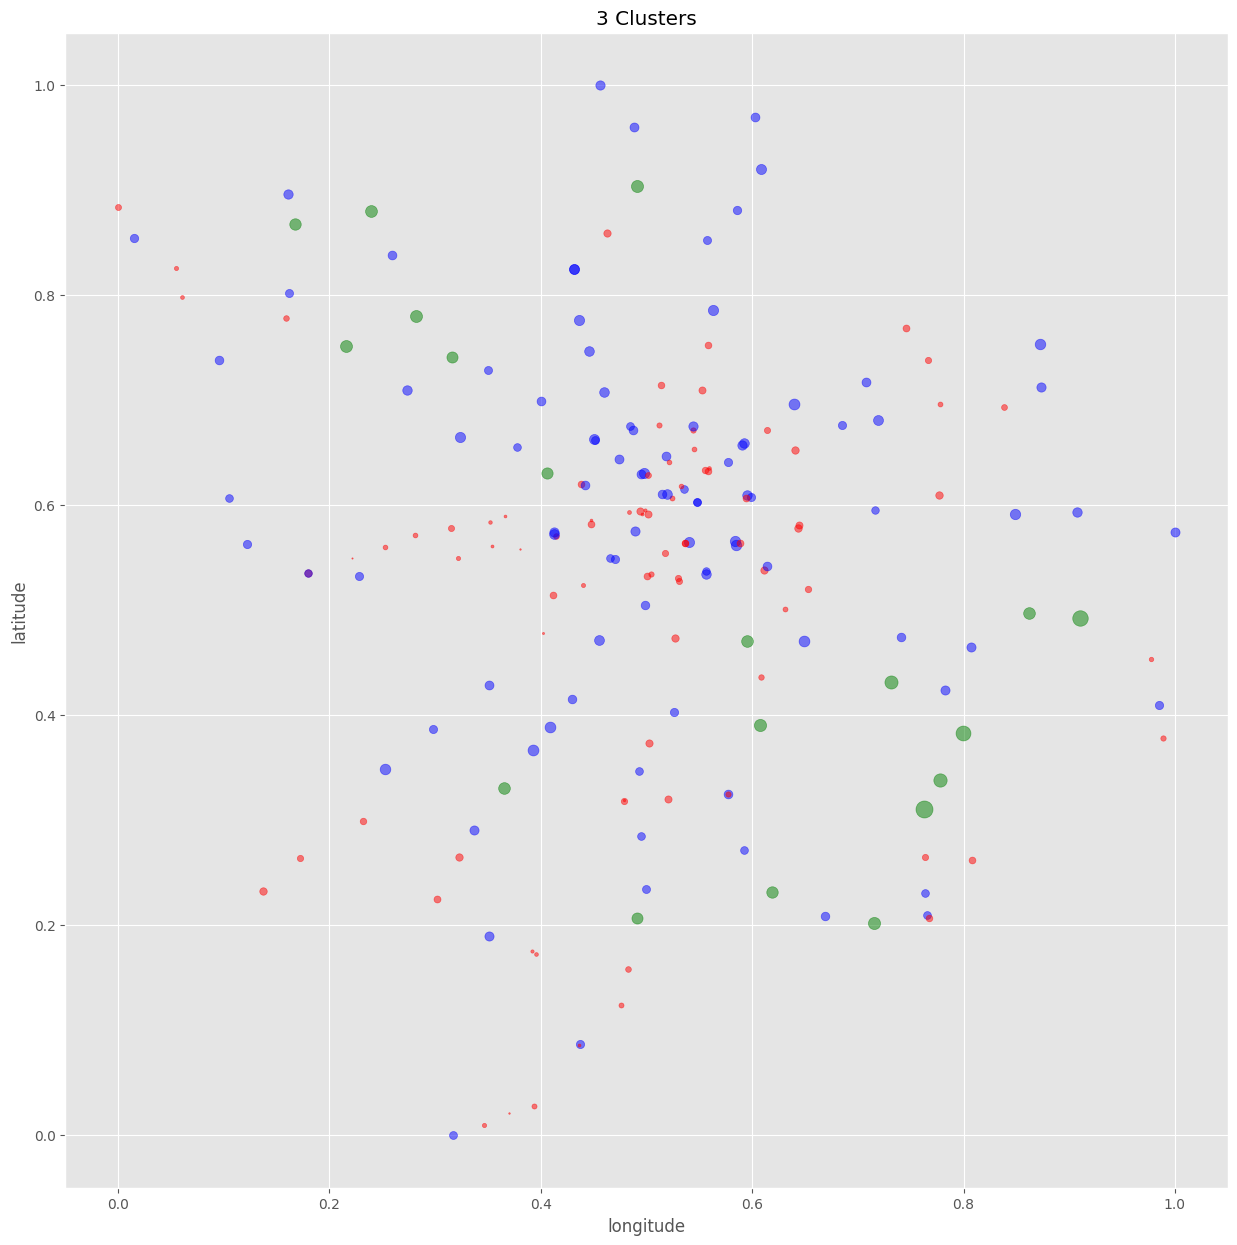

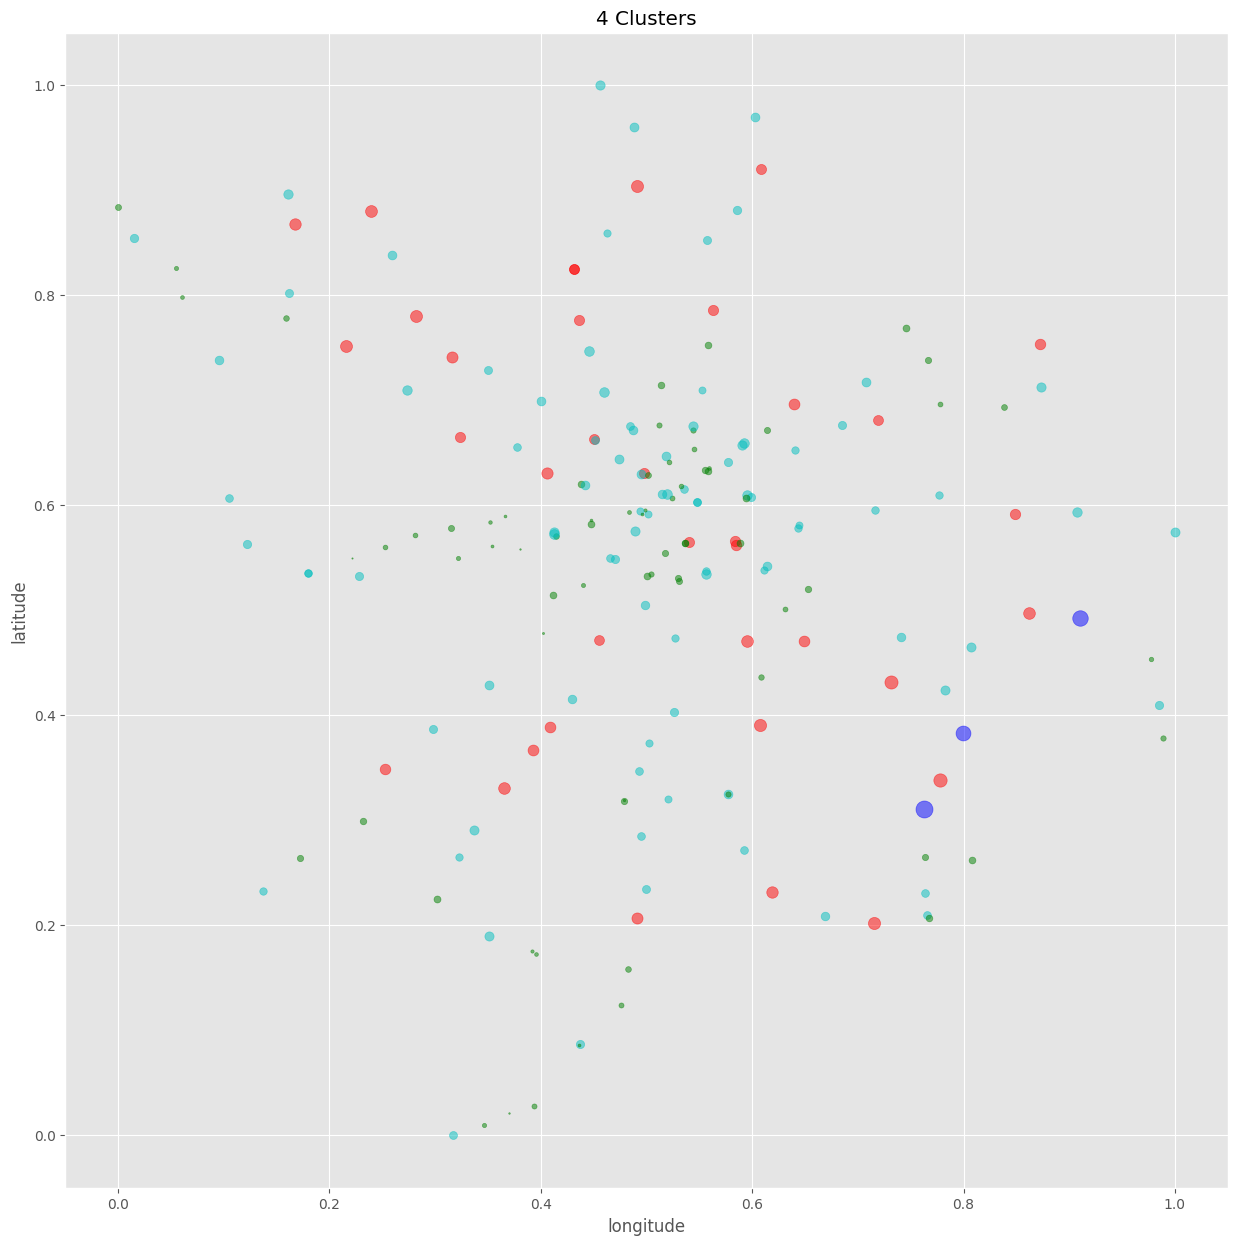

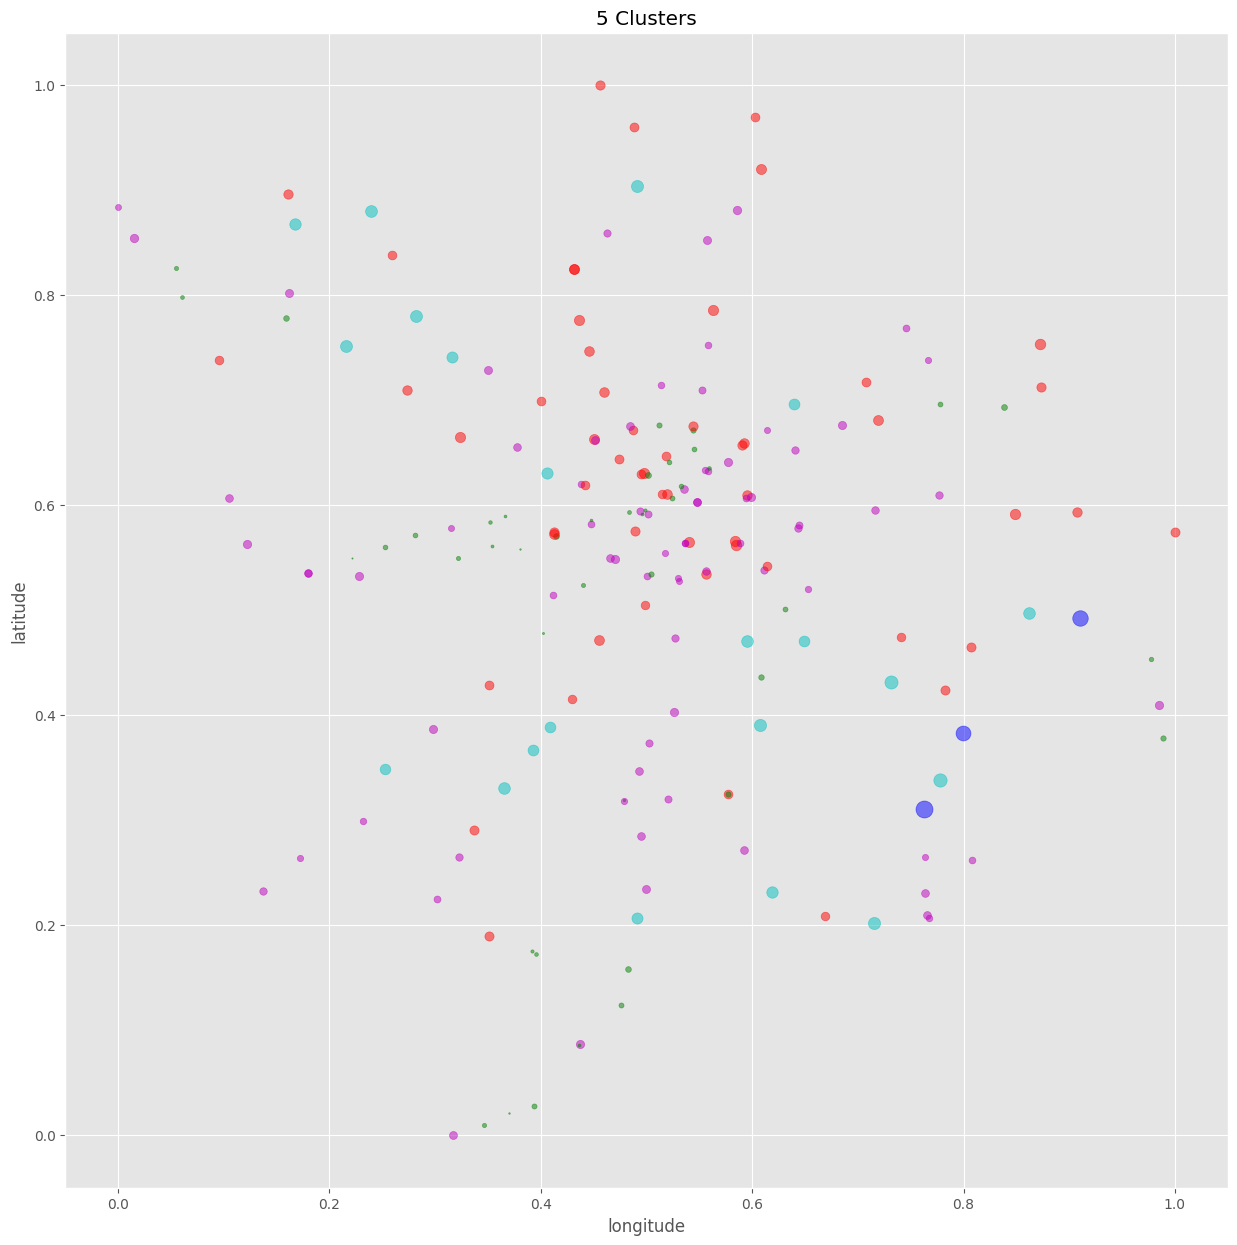

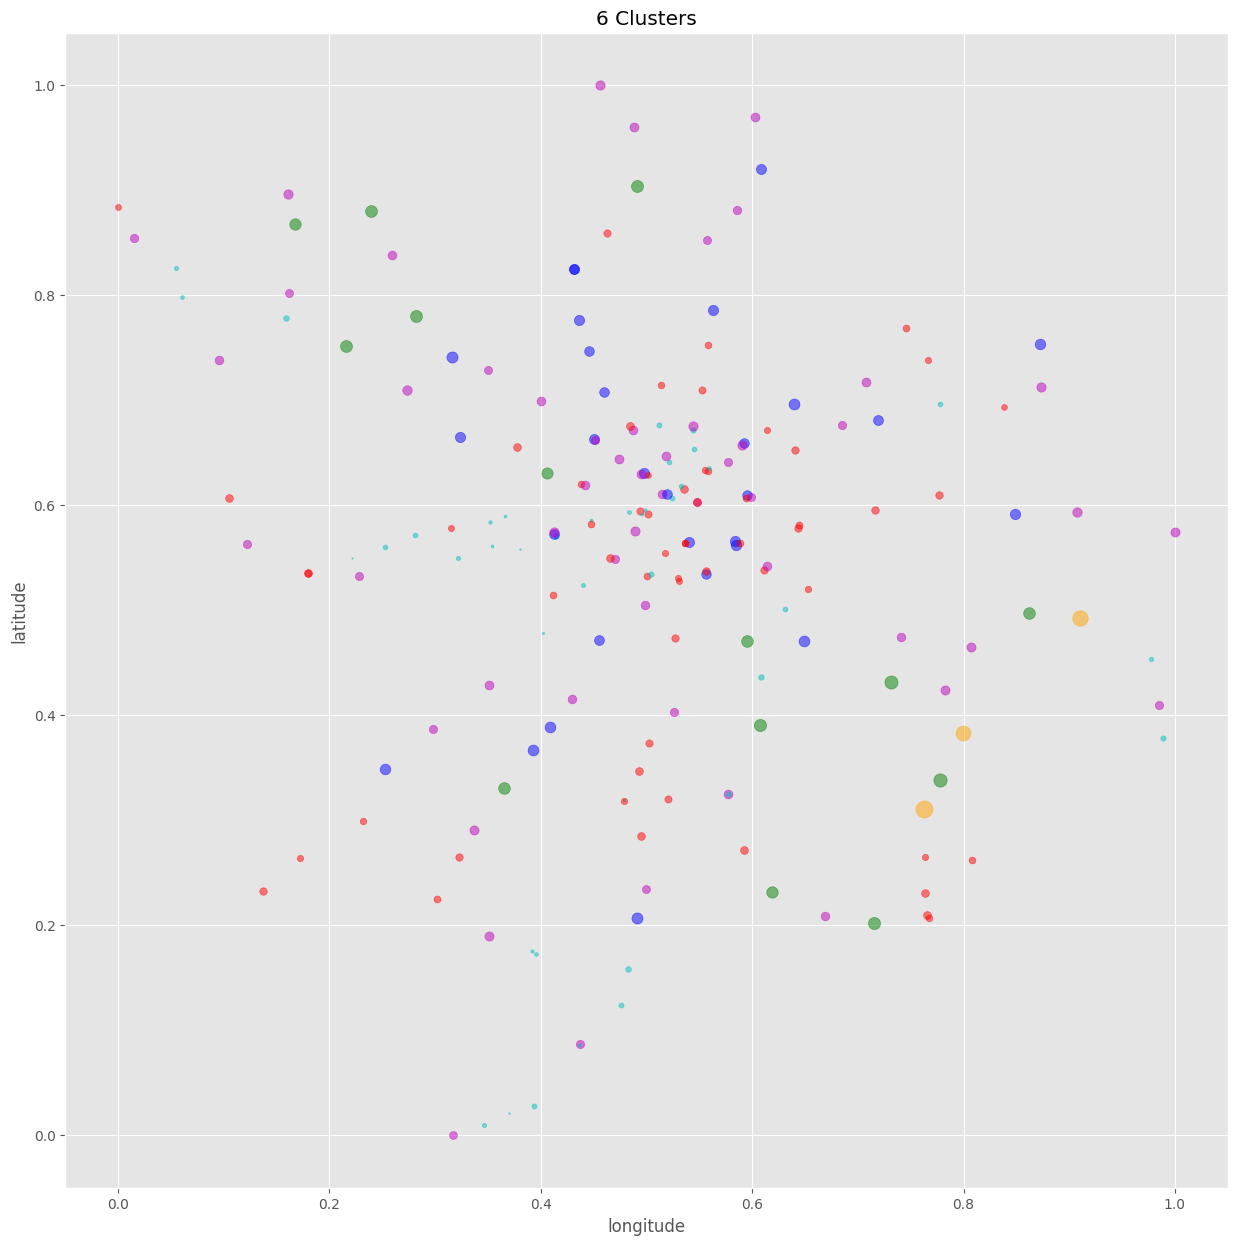

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(first_df)

    first_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_  # Cluster centers for colors definition

    plt.figure(figsize=(15, 15))

    for j in range(len(standard_df)):
        x = standard_df["longitude"][j]
        y = standard_df["latitude"][j]
        z = standard_df["potok"][j]
        cluster_label = model.labels_[j]
        plt.scatter(x, y, s=z*150, color=colors[cluster_label], alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(f'{i} Clusters')
    plt.show()

# Results Interpretation
Now the data is much clearer! What do we have?

1. First, my null hypothesis was not confirmed: the busiest stations are not necessarily in the center.

2. On the 6-cluster partition, three stations deep in residential areas are visible (according to the map, these are "Vykhino", "Lyublino", and "Maryino").

3. Based on the models, we can assume that partitions into 3, 4, and 5 clusters are the most successful and interpretable. A finer partition blurs clear cluster boundaries.

# Model and Result Evaluation

Let's conduct the final clustering and interpret the results.

In [ ]:
first_df.groupby('3_clusters')[['potok', 'latitude', 'longitude']].mean()

,potok,latitude,longitude
3_clusters,,,
0,21385.057471,55.720316,37.602018
1,100415.789474,55.724518,37.631974
2,52155.913978,55.747760,37.612467


**Evaluation:** For the 3-cluster partition, the interpretation is simplest. To understand the meaning of the coordinates, we locate these points on Yandex.Maps and use the assumption that Moscow is like a dartboard: the very center represents business districts, while the outer rings are residential.
**Therefore, the average coordinate only indicates the distance from the Kremlin.**
*   Cluster 0: The coordinate points to [the Neskuchny Garden](https://yandex.ru/maps/213/moscow/?ll=37.602625%2C55.720352&mode=search&sll=37.602018%2C55.720316&text=55.720316%2C37.602018&z=16) area. Passenger flow is low, meaning these are secondary, unpopular stations closer to working districts.
*   Cluster 1: Average coordinate is [Serpukhovskaya metro area](https://yandex.ru/maps/213/moscow/?ll=37.631712%2C55.724484&mode=search&sll=37.631974%2C55.724518&text=55.724518%2C37.631974&z=16). Stations located predominantly in residential areas, with elevated passenger flow
*   Cluster 2: Average coordinate - [Kremlin Embankment](https://yandex.ru/maps/213/moscow/?ll=37.617083%2C55.748075&mode=search&sll=37.612467%2C55.747760&text=55.747760%2C37.612467&z=16). Average passenger flow - stations in the center, enjoying uniform popularity among Muscovites. Possibly transfer hubs.

In [ ]:
first_df.groupby('4_clusters')[['potok', 'latitude', 'longitude']].mean()


,potok,latitude,longitude
4_clusters,,,
0,77766.666667,55.750139,37.617153
1,18622.222222,55.718704,37.600432
2,157600.000000,55.680463,37.774259
3,45519.318182,55.740704,37.608763


* Cluster 0: [The Kremlin](https://yandex.ru/maps/213/moscow/?ll=37.616962%2C55.750013&mode=search&sll=37.617153%2C55.750139&text=55.750139%2C37.617153&z=16). Stations with large passenger flow encircling the center. This is Cluster 2 from the previous case.

*   Cluster 1: [Near Neskuchny Garden](https://yandex.ru/maps/213/moscow/?ll=37.600029%2C55.718836&mode=search&sll=37.600432%2C55.718704&text=55.718704%2C37.600432&z=16). Low passenger flow. This is Cluster 0 from the previous case.

And Cluster 1 from the previous case split into two new clusters:
*   Cluster 2: [Lyublino residential area](https://yandex.ru/maps/213/moscow/?ll=37.770637%2C55.678803&mode=search&sll=37.774259%2C55.680463&text=55.680463%2C37.774259&z=16). Stations with excessive passenger flow in working quarters.
*   Cluster 3: [Bersenevskaya Embankment](https://yandex.ru/maps/213/moscow/?ll=37.609263%2C55.740654&mode=search&sll=37.608763%2C55.740704&text=55.740704%2C37.608763&z=16). Center, average passenger flow.


In [ ]:
first_df.groupby('5_clusters')[['potok', 'latitude', 'longitude']].mean()


,potok,latitude,longitude
5_clusters,,,
0,56676.363636,55.765237,37.625566
1,12679.545455,55.711787,37.589886
2,157600.000000,55.680463,37.774259
3,85952.380952,55.725370,37.602407
4,35078.947368,55.727555,37.605369


*   Cluster 0 - [Boulevard Ring](https://yandex.ru/maps/213/moscow/?ll=37.625720%2C55.765205&mode=search&sll=37.625566%2C55.765237&text=55.765237%2C37.625566&z=16). Stations with average passenger flow, center.
*   Cluster 1 - [Leninsky Prospekt, Third Transport Ring](https://yandex.ru/maps/213/moscow/?ll=37.589832%2C55.711539&mode=search&sll=37.589886%2C55.711787&text=55.711787%2C37.589886&z=16). Low passenger flow, not the very center.
*   Cluster 2 - [Lyublino residential area](https://yandex.ru/maps/213/moscow/?ll=37.770637%2C55.678803&mode=search&sll=37.774259%2C55.680463&text=55.680463%2C37.774259&z=16). Stations with excessive passenger flow in working quarters.
* Cluster 3 - [Near Gorky Park](https://yandex.ru/maps/213/moscow/?ll=37.602364%2C55.725356&mode=search&sll=37.602407%2C55.725370&text=55.725370%2C37.602407&z=16). Flow above average, center.
*   Cluster 4 - [Gorky Park](https://yandex.ru/maps/213/moscow/?ll=37.605283%2C55.727592&mode=search&sll=37.605369%2C55.727555&text=55.727555%2C37.605369&z=16). Stations with small passenger flow, evenly distributed throughout the network.

It seems sufficient to distinguish 3-4 clusters to fully describe the passenger flow at Moscow Metro stations.

# Clustering "depth-passenger flow-construction date"
Now let's try to find a dependency between the depth of the station, the date of construction, and the passenger flow. We will place the points in "depth-construction date" coordinates, and denote passenger flow by the thickness of the point.

**Null hypothesis:** Deep stations were built quite late because in the 1930s technologies did not allow digging too deep. Older stations have higher passenger flow because they were built primarily to serve large masses of the population. Passenger flow does not correlate with depth.

In [ ]:
second_df = float_df.copy()
second_df = second_df[['potok', 'newness', 'depth']]

K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 111, n_init = 100, max_iter = 10000).fit(second_df) for k in K]
dist = [model.inertia_ for model in models]

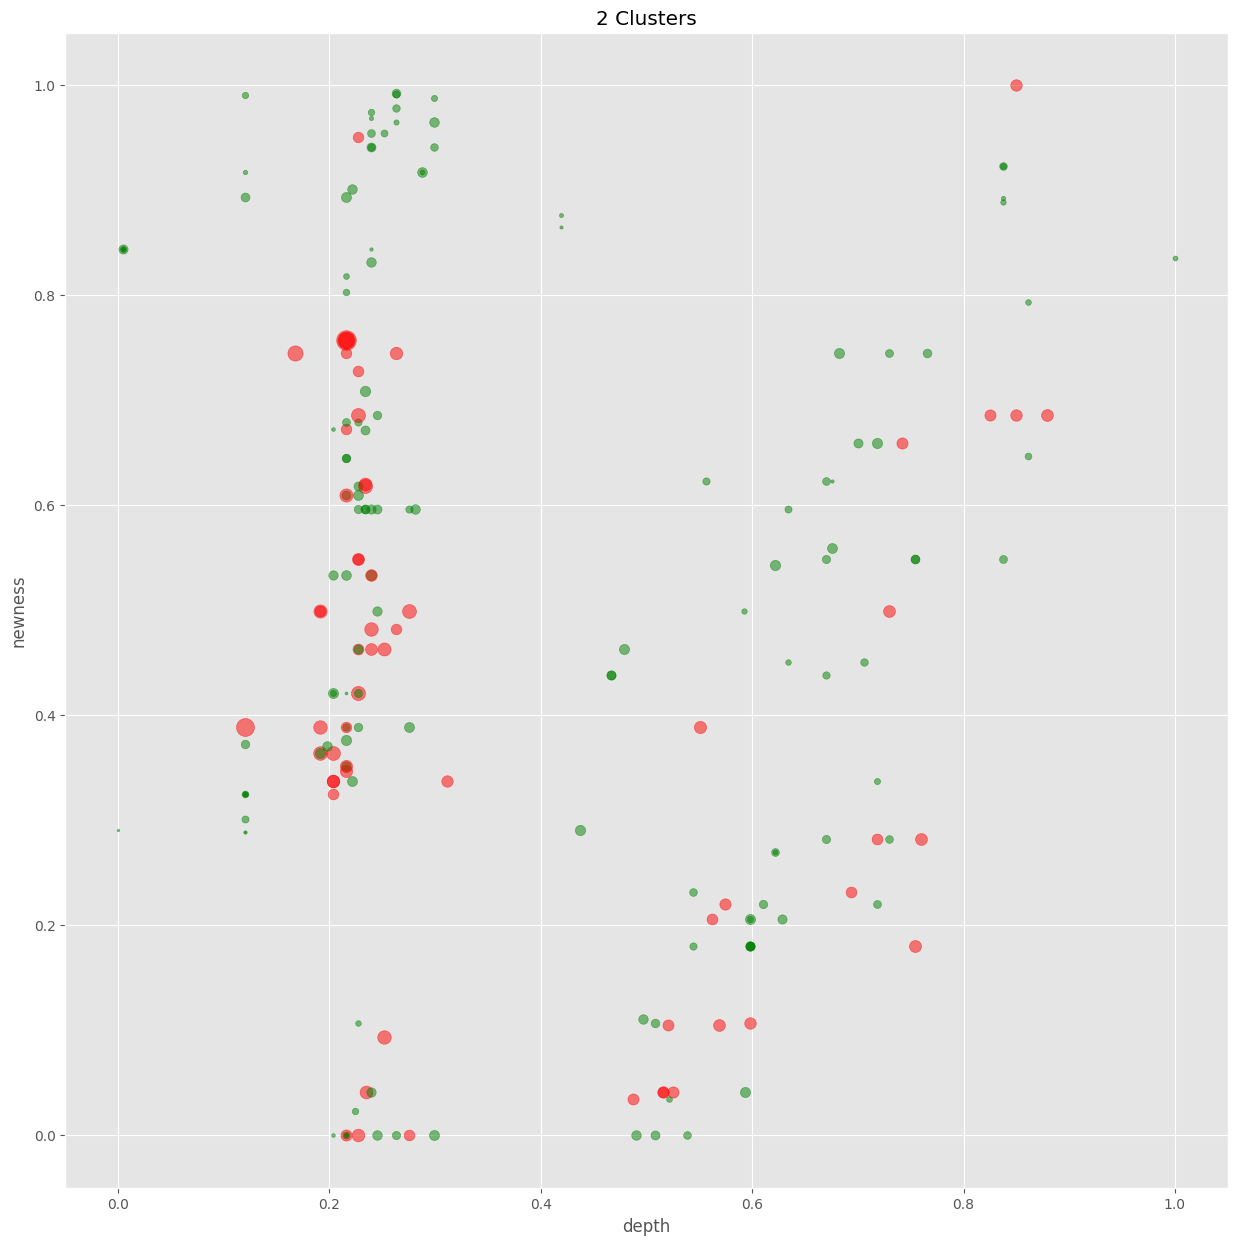

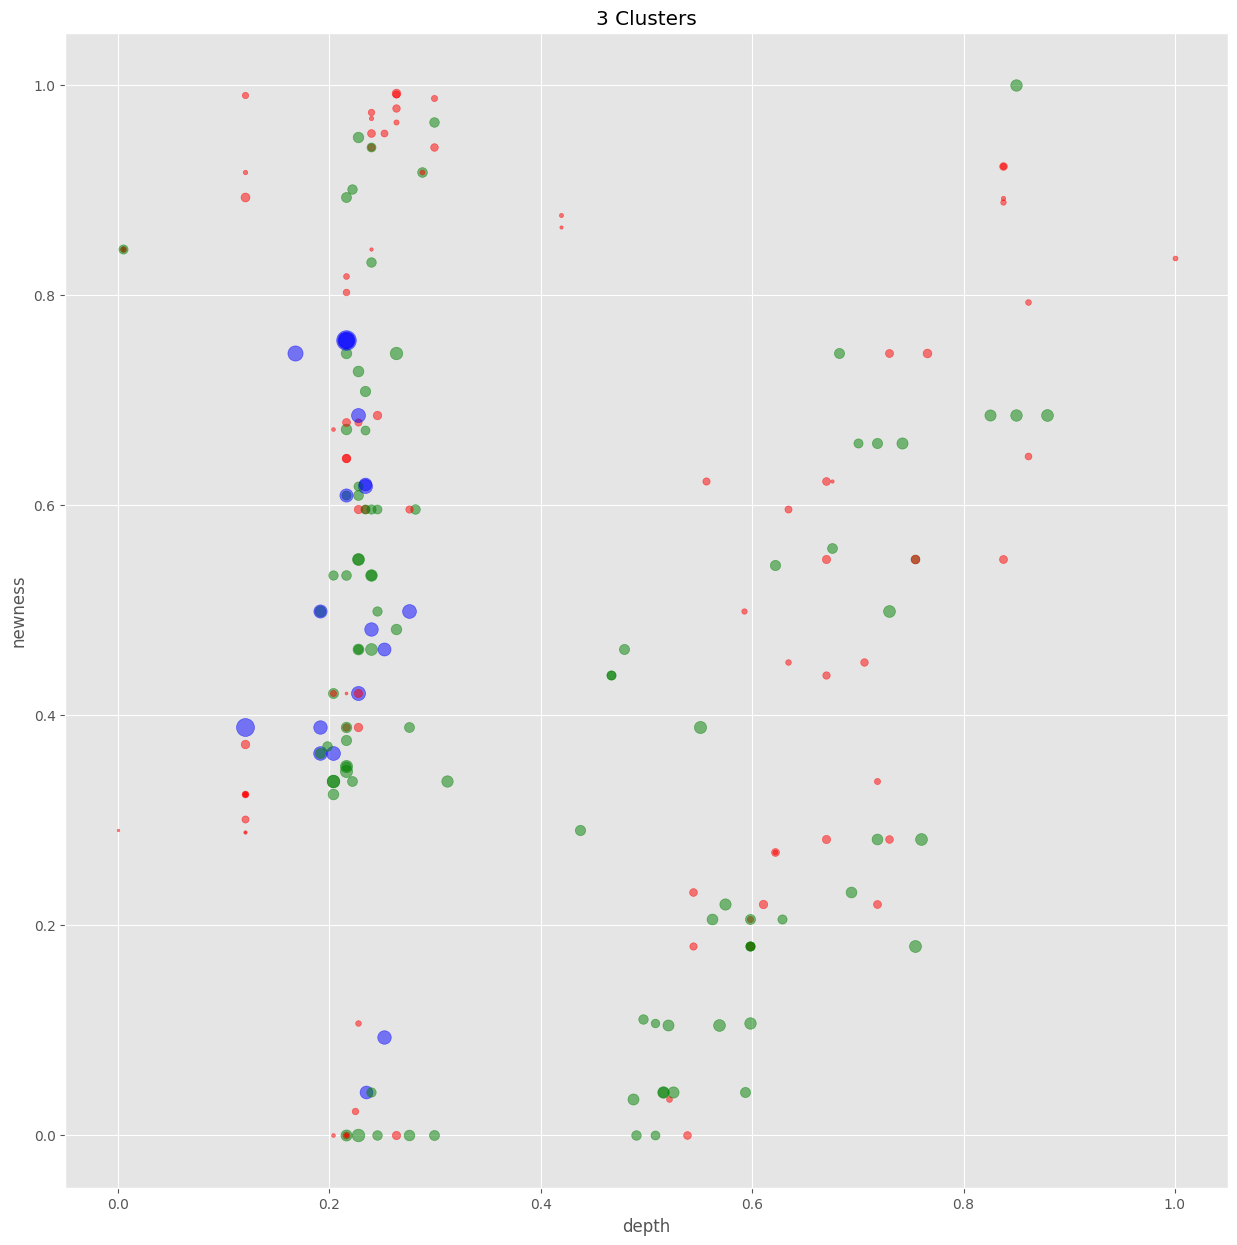

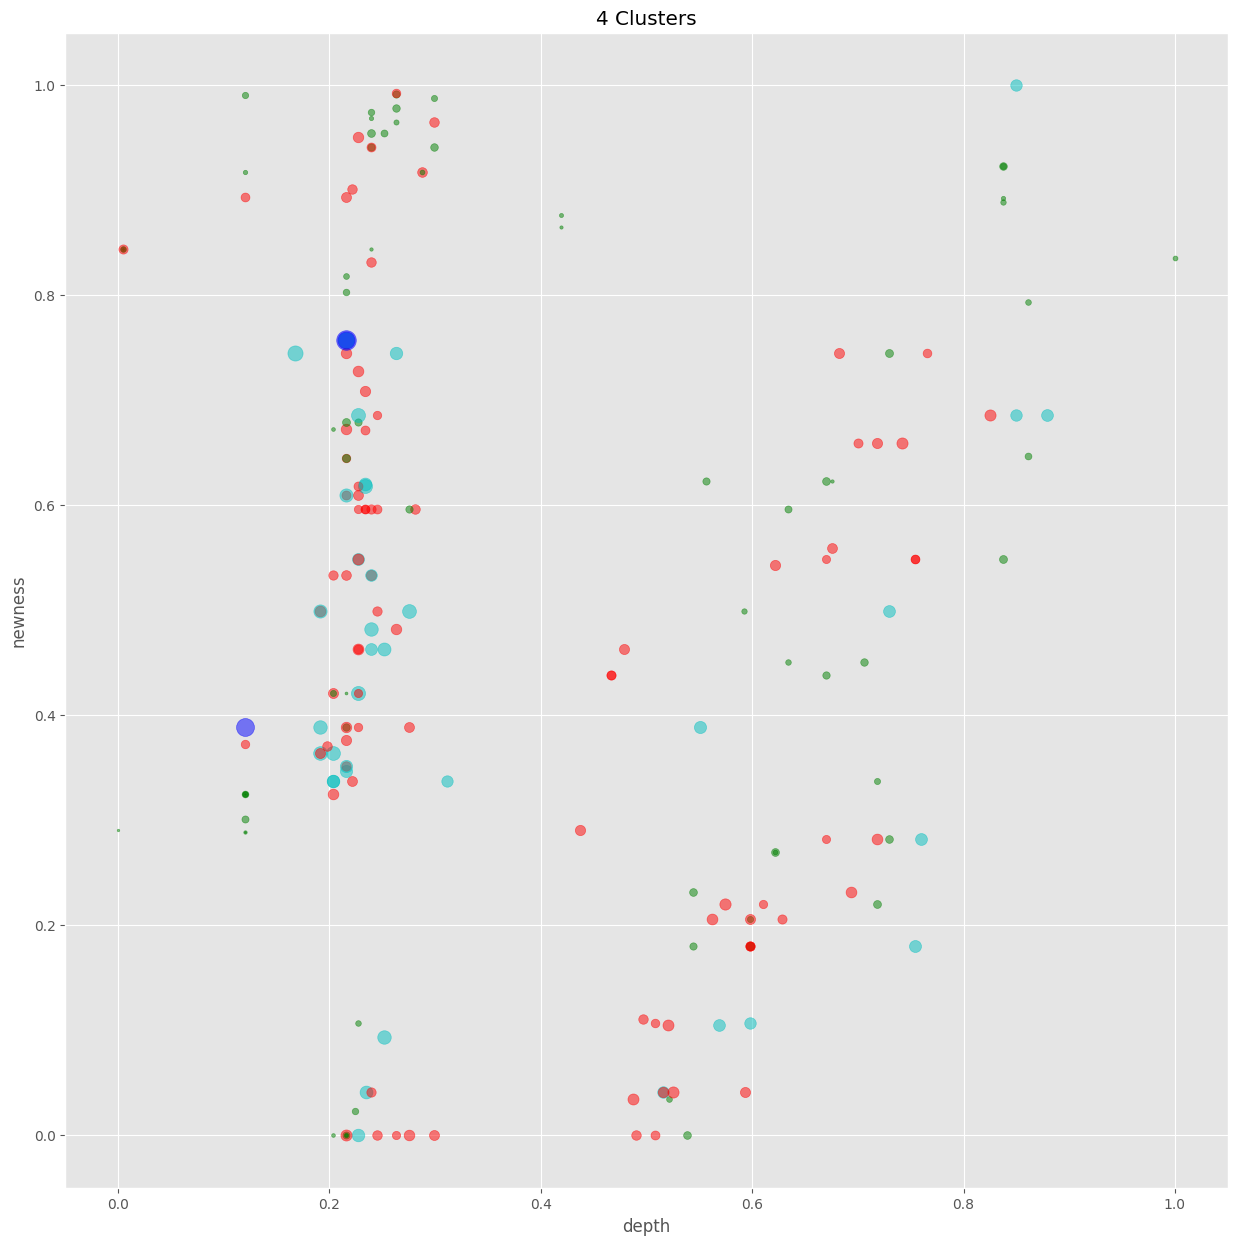

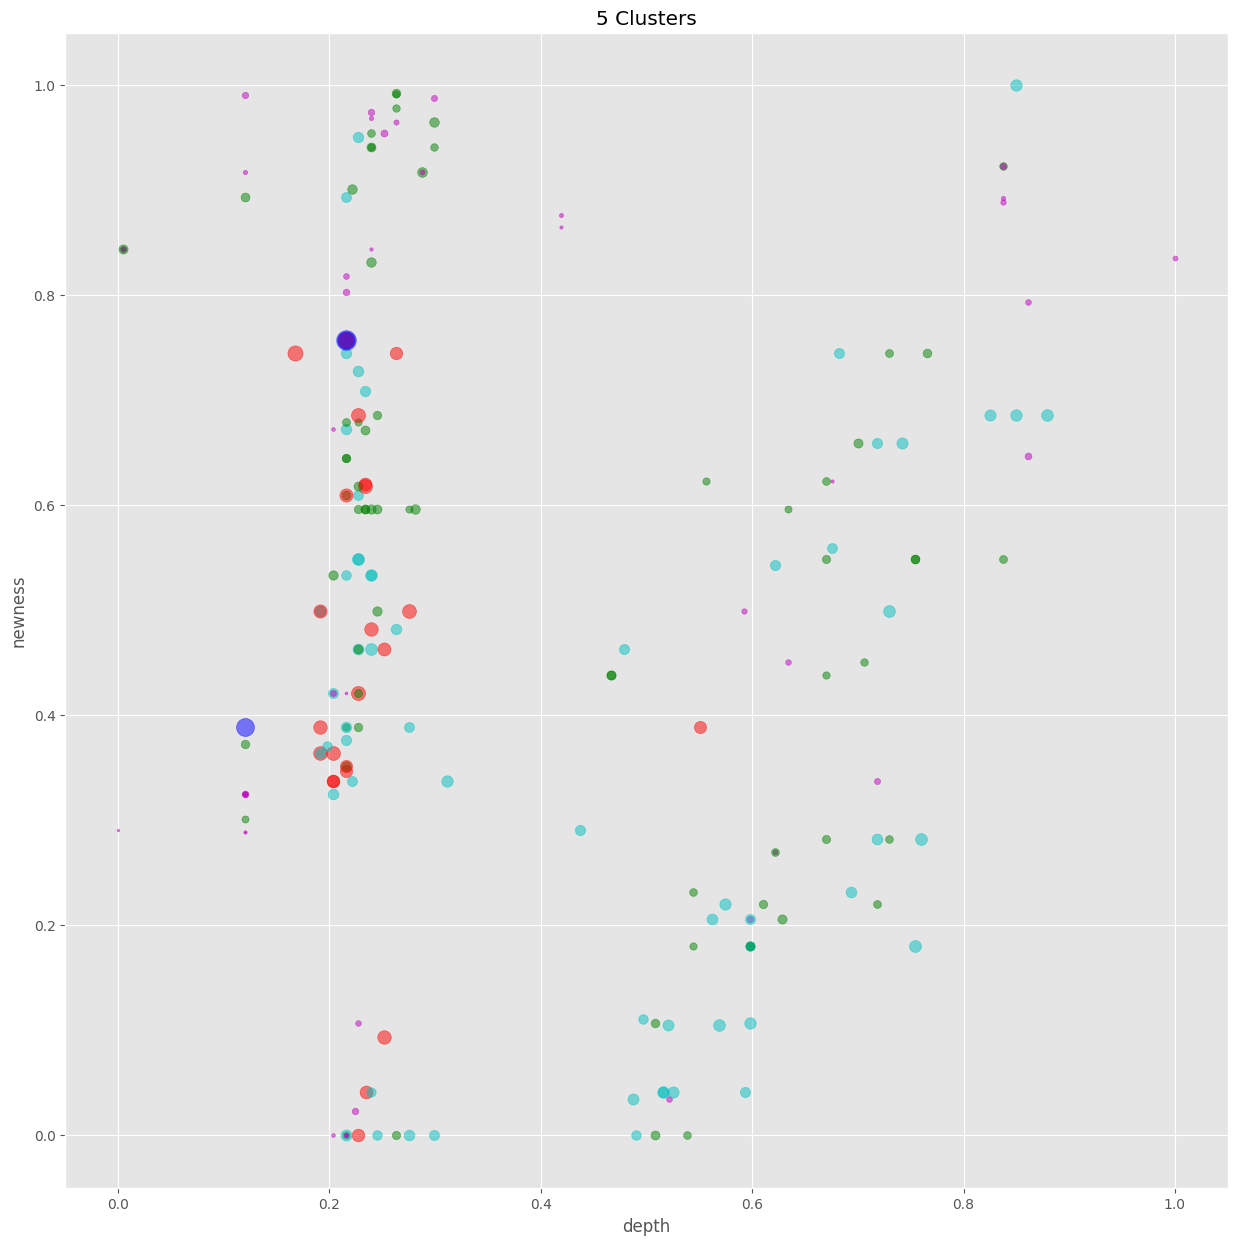

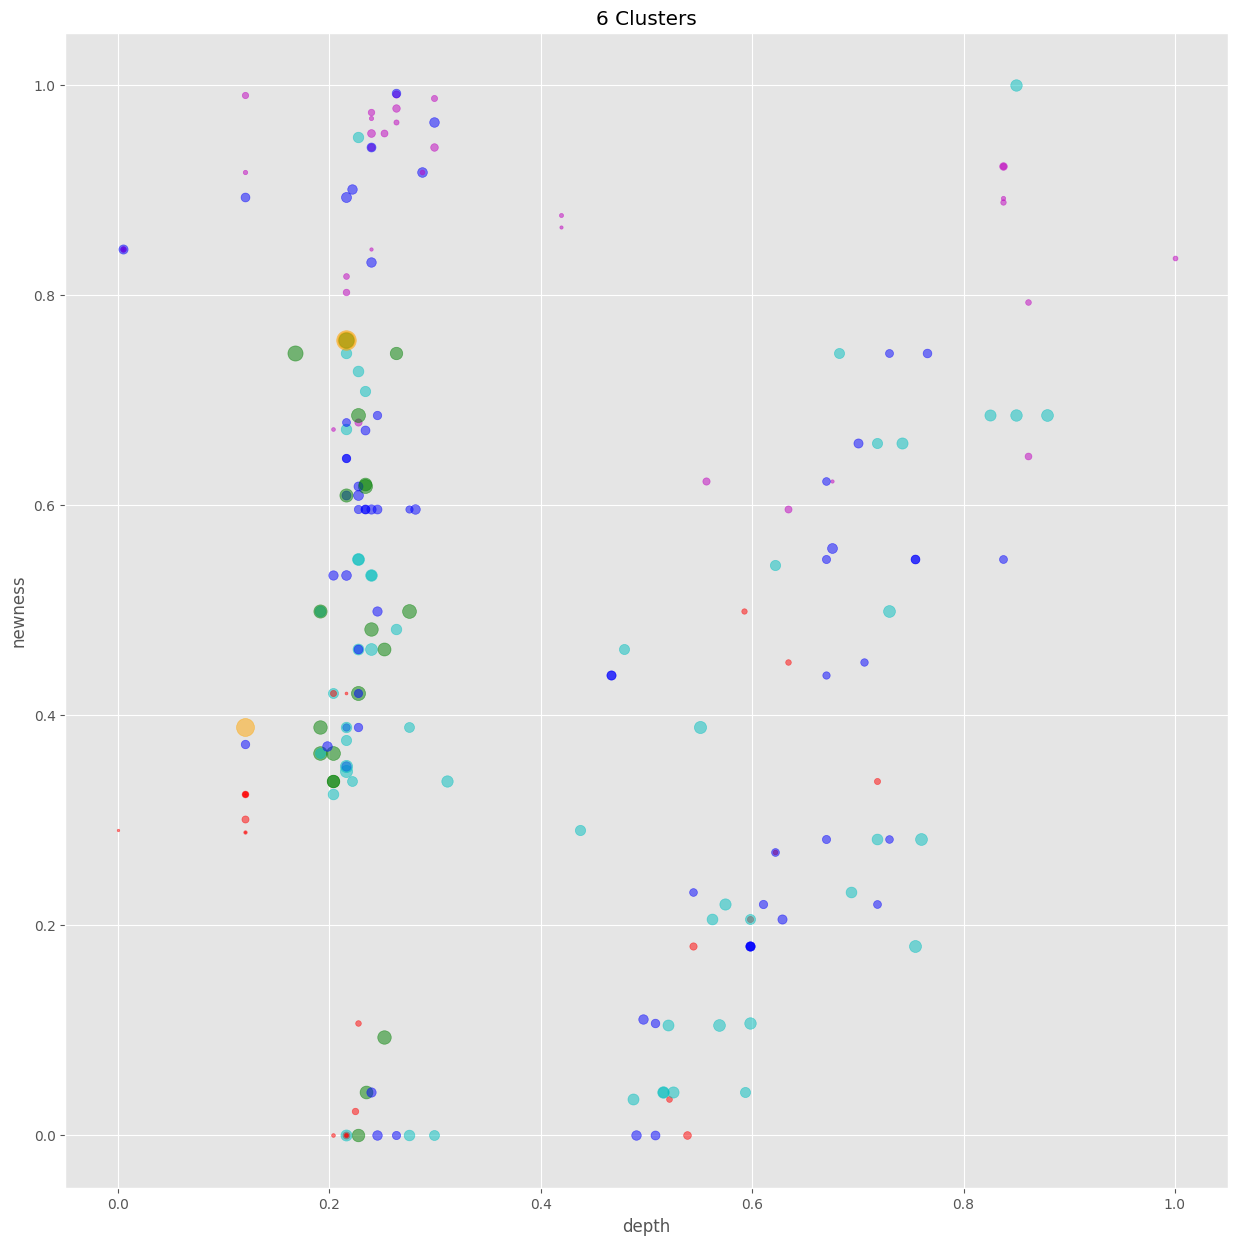

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(second_df)

    second_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_

    plt.figure(figsize=(15, 15))

    for j in range(len(standard_df)):
        x = standard_df["depth"][j]
        y = standard_df["newness"][j]
        z = standard_df["potok"][j]
        cluster_label = model.labels_[j]
        plt.scatter(1-x, y, s=z*200, color=colors[cluster_label], alpha=0.5)


    plt.xlabel('depth')
    plt.ylabel('newness')
    plt.title(f'{i} Clusters')
    plt.show()

What do we see in the resulting images? Firstly, the majority of stations are shallow. Secondly, deep stations generally have fewer people. Otherwise, the null hypothesis was confirmed.

# Second model evaluation

In [ ]:
second_df.groupby('3_clusters')[['depth', 'newness', 'potok']].mean()

,depth,newness,potok
3_clusters,,,
0,-22.604598,16712.770115,21408.045977
1,-23.218280,12761.602151,52134.408602
2,-8.031579,14948.210526,100415.789474


The average opening dates:

In [ ]:
import datetime
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16713)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 12762)
date_3 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 14948)
print(date_1, date_2, date_3)

1981-02-15 00:00:00 1970-04-23 00:00:00 1976-04-17 00:00:00


The partition into three clusters, as it turned out, yields no results regarding depth, but quite clearly describes the opening date relative to passenger flow.

* Cluster 0: Stations with small passenger flow, opened on average in 1981. It is characteristic that this date falls into the era of "Brezhnev stagnation," when stations were opened at a rapid pace and without particular need for them.

* Cluster 1: Stations with average passenger flow, including the oldest ones (and the most necessary as of 1935).

* Cluster 2: Stations with large passenger flow, the average date for which falls on the active construction of Moscow residential quarters.

Трёхкластерное разбиение оказалось нерепрезентативным. Идём дальше.

In [ ]:
second_df.groupby('4_clusters')[['depth', 'newness', 'potok']].mean()

,depth,newness,potok
4_clusters,,,
0,-21.507955,13474.034091,45519.318182
1,-22.883333,16919.583333,18622.222222
2,-5.333333,18855.333333,157600.000000
3,-20.061111,12899.027778,77766.666667


In [ ]:
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 13474)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16920)
date_3 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 18855)
date_4 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 12899)
print(date_1, date_2, date_3, date_4)

1972-04-04 00:00:00 1981-09-10 00:00:00 1986-12-28 00:00:00 1970-09-07 00:00:00


* Cluster 0: Stations with average passenger flow, opened on average in 1972, shallow depth.

* Cluster 1: Stations slightly deeper with low passenger flow, opened on average in 1981.

* Cluster 2: Stations with excessive passenger flow (all the same "Maryino", "Lyublino", and "Vykhino") of shallow depth. Opened closer to the collapse of the USSR (in reality "Vykhino" opened in 1966, and the other two in 1996).

* Cluster 3: Stations with above-average flow, medium depth, opened (on average) in 1970.

In [ ]:
second_df.groupby('5_clusters')[['depth', 'newness', 'potok']].mean()

,depth,newness,potok
5_clusters,,,
0,-9.721739,13127.347826,84634.782609
1,-23.704412,16005.455882,34329.411765
2,-5.333333,18855.333333,157600.000000
3,-26.215000,11463.966667,54720.000000
4,-18.980000,17558.933333,12931.111111


In [ ]:
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 13127)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16005)
date_4 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 11463)
date_5 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 17558)
print(date_1, date_2, date_4, date_5)

1971-04-23 00:00:00 1979-03-10 00:00:00 1966-10-02 00:00:00 1983-06-10 00:00:00


* Cluster 0: Shallow, on average old stations with large passenger flow.

* Cluster 1: Depth greater than average, and passenger flow less than average. Average opening date 1979.

* Cluster 2: Similar to the previous point.

* Cluster 3: Quite old stations with average passenger flow and great depth.

* Cluster 4: On average new stations with small passenger flow, not standing out by depth.

# Conclusions
No matter how you look at it, explaining the meaning of the cluster in the last point was quite difficult. Each time, we had to "force a fit" (stretch the map onto the globe) and look for patterns that the mean value does not capture (stations are scattered chaotically across our graphs, and the average date reveals practically nothing).

We thus arrive at the conclusion that data can be clustered by passenger flow and coordinates with fairly logical deductions, whereas [passenger flow — depth — date] cannot be effectively divided into a small number of clusters.